<a href="https://colab.research.google.com/github/Diljitsingh14/Colab-Notebooks/blob/main/GPT_2_fine_tune_using_LoRA_keras_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Large Language Models (LLMs) have been shown to be effective at a variety of NLP
tasks. An LLM is first pre-trained on a large corpus of text in a
self-supervised fashion. Pre-training helps LLMs learn general-purpose knowledge,
such as statistical relationships between words. An LLM can then be fine-tuned
on a downstream task of interest (such as sentiment analysis).

However, LLMs are extremely large in size, and we don't need to train all the
parameters in the model while fine-tuning, especially because datasets on which
the model is fine-tuned are relatively small. Another way of saying this is
that LLMs are over-parametrized for fine-tuning. This is where
[Low-Rank Adaptation (LoRA)](https://arxiv.org/abs/2106.09685) comes in; it
significantly reduces the number of trainable parameters. This results in a
decrease in training time and GPU memory usage, while maintaining the quality
of the outputs.

In this example, we will explain LoRA in technical terms, show how the technical
explanation translates to code, hack KerasNLP's
[GPT-2 model](https://keras.io/api/keras_nlp/models/gpt2/) and fine-tune
it on the next token prediction task using LoRA. We will compare LoRA GPT-2
with a fully fine-tuned GPT-2 in terms of the quality of the generated text,
training time and GPU memory usage.

Note: This example runs on the TensorFlow backend purely for the
`tf.config.experimental.get_memory_info` API to easily plot memory usage.
Outside of the memory usage callback, this example will run on `jax` and `torch`
backends.

## Setup

In [1]:
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.8/584.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.2 which is incompatible.


In [2]:
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras_nlp
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import time

In [3]:
## Define Hyperparams
BATCH_SIZE = 32
MAX_SEQUENCE_LENGTH = 128
MAX_GENERATION_LENGTH = 200
NUM_EPOCHS = 1
NUM_BATCHES = 500

# model
MODEL_PRESET = "gpt2_base_en"

# lora config
RANK = 4
ALPHA = 32.0

In [4]:
reddit_ds = tfds.load('reddit_tifu',split='train',as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/79740 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/reddit_tifu/short/1.1.2.incompleteYIZOSM/reddit_tifu-train.tfrecord*...:  …

Dataset reddit_tifu downloaded and prepared to /root/tensorflow_datasets/reddit_tifu/short/1.1.2. Subsequent calls will reuse this data.


In [5]:
for document,title in reddit_ds:
  print(document)
  print(title)
  break;


tf.Tensor(b"me and a friend decided to go to the beach last sunday. we loaded up and headed out. we were about half way there when i decided that i was not leaving till i had seafood. \n\nnow i'm not talking about red lobster. no friends i'm talking about a low country boil. i found the restaurant and got directions. i don't know if any of you have heard about the crab shack on tybee island but let me tell you it's worth it. \n\nwe arrived and was seated quickly. we decided to get a seafood sampler for two and split it. the waitress bought it out on separate platters for us. the amount of food was staggering. two types of crab, shrimp, mussels, crawfish, andouille sausage, red potatoes, and corn on the cob. i managed to finish it and some of my friends crawfish and mussels. it was a day to be a fat ass. we finished paid for our food and headed to the beach. \n\nfunny thing about seafood. it runs through me faster than a kenyan \n\nwe arrived and walked around a bit. it was about 45min 

In [6]:
train_ds = reddit_ds.map(lambda document,_: document).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE).take(NUM_BATCHES)

In [19]:
class GPUMemoryCallback(keras.callbacks.Callback):
  def __init__(
        self,
        target_batches,
        print_stats=False,
        **kwargs,
    ):
    super().__init__(**kwargs)

    self.target_batches = target_batches
    self.print_stats = print_stats

    self.memory_usage = []
    self.labels = []

  def _compute_memory_usage(self):
    memory_usage = tf.config.experimental.get_memory_info('GPU:0')

    peak_usage = round(memory_usage['peak']/(2**30),3)
    self.memory_usage.append(peak_usage)


  def on_epochs_begin(self, epoch,logs=None):
    self._compute_memory_usage()
    self.labels.append(f"epoch {epoch} start")

  def on_train_batch_begin(self, batch, logs=None):
    if batch in self.target_batches:
      self._compute_memory_usage()
      self.labels.append(f"batch {batch} start")

  def on_epoch_end(self, epoch, logs=None):
    self._compute_memory_usage()
    self.labels.append(f"epoch {epoch} end")



In [8]:
def generate_text(model,input_text,max_length=MAX_GENERATION_LENGTH):
  t1 = time.time()

  output = model.generate(input_text,max_length=max_length)
  print(f"output : {output}")

  t2 = time.time()

  print(f"Time take to generate : {t2-t1:.2f}s")

In [9]:
def get_optimizer_loss():
  learning_rate = keras.optimizers.schedules.PolynomialDecay(5e-5,decay_steps=0.01)
  optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)

  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  return optimizer,loss

def get_optimizer_and_loss_beta():
  optimizer = keras.optimizers.AdamW(learning_rate=5e-5,
                                     weight_decay=0.01,
                                     epsilon=1e-6,
                                     global_clipnorm=1.0)

  optimizer.exclude_from_weight_decay(var_names=['bias'])
  optimizer.exclude_from_weight_decay(var_names=['gamma'])
  optimizer.exclude_from_weight_decay(var_names=['beta'])

  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  return optimizer,loss


In [21]:
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(MODEL_PRESET,sequence_length=MAX_SEQUENCE_LENGTH)

gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset(MODEL_PRESET,preprocessor=preprocessor)
gpt2_lm.summary()

Preprocessor: "gpt2_causal_lm_preprocessor_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer_3 (GPT2Tokenizer)                   │                                              50,257 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gpt2_causal_lm_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gpt2_backbone_2               │ (None, None, 768)         │ 124,439,808 │ padding_mask[0][0],            │
│ (GPT2Backbone)                │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_embedding               │ (None, None, 50257)       │  38,597,376 │ gpt2_backbone_2[0][0]          │
│ (ReversibleEmbedding)         │                           │             │                                │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 124,439,808 (474.70 MB)

 Trainable params: 124,439,808 (474.70 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
gpu_memory_callback = GPUMemoryCallback(target_batches=[5, 10, 25, 50, 100, 150, 200, 300, 400, 500],
    print_stats=True,)

optimizer,loss = get_optimizer_and_loss_beta()

gpt2_lm.compile(optimizer=optimizer,loss=loss,weighted_metrics=['accuracy'])


In [23]:
gpt2_lm.fit(train_ds,epochs=NUM_EPOCHS,callbacks=[gpu_memory_callback])
gpt2_lm_memory_usage = gpu_memory_callback.memory_usage

500/500 ━━━━━━━━━━━━━━━━━━━━ 662s 1s/step - accuracy: 0.3182 - loss: 3.3691


In [25]:
generate_text(gpt2_lm,"I like cricket")
generate_text(gpt2_lm,"That indian hotel")

output : I like cricket.  i've played it for a while, and my friend is an excellent bowler.  so when he was in school, he would always play with me.  he'd play with me when he was younger.  he was a very good bowler, he'd get the ball in his hand, hit it, throw it, and hit a ball.  he would hit it again.


i'd play with him when he was younger.  he would always hit the ball with me, and he would hit me.  he'd hit me with a big ball.  he'd hit me with a big ball.  i
Time take to generate : 42.36s
output : That indian hotel room that you can get in your city for $200?

it's called the barbershop.

so i've been working at the barbershop for a few weeks and have been working at it for about an hour. i was supposed to come back from my internship today and get the barbershop's attention. so i go in, grab the barbershop's key and head to the front of the hotel.

there's no one there, so i head in, grab the key, grab the key, go to the front and go
Time take to generate : 0.49s


In [26]:
gpt2_lm_memory_usage

[8.083, 8.083, 8.083, 8.083, 8.083, 8.083, 8.083, 8.083, 8.083, 8.083]

## LoRA GPT-2

In this section, we discuss the technical details of LoRA, build a LoRA GPT-2
model, fine-tune it and generate text.

### What exactly is LoRA?

LoRA is a parameter-efficient fine-tuning technique for LLMs. It freezes the
weights of the LLM, and injects trainable rank-decomposition matrices. Let's
understand this more clearly.

Assume we have an `n x n` pre-trained dense layer (or weight matrix), `W0`. We
initialize two dense layers, `A` and `B`, of shapes `n x rank`, and `rank x n`,
respectively. `rank` is much smaller than `n`. In the paper, values between 1
and 4 are shown to work well.


#### LoRA equation

The original equation is `output = W0x + b0`, where `x` is the input, `W0` and
`b0` are the weight matrix and bias terms of the original dense layer (frozen).
The LoRA equation is: `output = W0x + b0 + BAx`, where `A` and `B` are the
rank-decomposition matrices.

LoRA is based on the idea that updates to the weights of the pre-trained
language model have a low "intrinsic rank" since pre-trained language models are
over-parametrized. Predictive performance of full fine-tuning can be replicated
even by constraining `W0`'s updates to low-rank decomposition matrices.

<p align="center">
  <img src="https://i.imgur.com/f4TFqMi.png" alt="lora_diagram" height="250"/>
</p>
<br>

#### Number of trainable parameters

Let's do some quick math. Suppose `n` is 768, and `rank` is 4. `W0` has
`768 x 768 = 589,824` parameters, whereas the LoRA layers, `A` and `B` together
have `768 x 4 + 4 x 768 = 6,144` parameters. So, for the dense layer, we go from
`589,824` trainable parameters to `6,144` trainable parameters!

#### Why does LoRA reduce memory footprint?

Even though the total number of parameters increase (since we are adding LoRA
layers), the memory footprint reduces, because the number of trainable
parameters reduces. Let's dive deeper into this.

The memory usage of a model can be split into four parts:

- Model memory: This is the memory required to store the model weights. This
will be slightly higher for LoRA than GPT-2.
- Forward pass memory: This mostly depends on batch size, sequence length, etc.
We keep this constant for both models for a fair comparison.
- Backward pass memory: This is the memory required to store the gradients.
Note that the gradients are computed only for the trainable parameters.
- Optimizer memory: This is the memory required to store the optimizer state.
For example, the Adam optimizer stores the "1st moment vectors" and
"2nd moment vectors" for the trainable parameters.

Since, with LoRA, there is a huge reduction in the number of trainable
parameters, the optimizer memory and the memory required to store the gradients
for LoRA is much less than GPT-2. This is where most of the memory savings
happen.

#### Why is LoRA so popular?

- Reduces GPU memory usage;
- Faster training; and
- No additional inference latency.

### Create LoRA layer

According to the technical description above, let's create a LoRA layer. In
a transformer model, the LoRA layer is created and injected for the query and
value projection matrices. In `keras.layers.MultiHeadAttention`, the query/value
projection layers are `keras.layers.EinsumDense` layers.

In [54]:
import math

class LoraLayer(keras.layers.Layer):
  def __init__(self,original_layers,rank,alpha,trainable=False,**kwargs):
    original_layers_configs = original_layers.get_config()
    name = original_layers_configs['name']

    kwargs.pop("name", None)

    super().__init__(name=name,trainable=trainable,**kwargs)

    self.rank = rank
    self.alpha = alpha

    self._scale = alpha/rank


    self._num_heads = original_layers_configs['output_shape'][-2]
    self._hidden_dim = self._num_heads * original_layers_configs['output_shape'][-1]


    self.original_layers = original_layers
    self.original_layers.trainable = False

    self.A = keras.layers.Dense(units=rank,
                                use_bias=False,
                                kernel_initializer=keras.initializers.VarianceScaling(scale=math.sqrt(5),
                                                                                      distribution='uniform'),
                                trainable=trainable,
                                name='lora_A',)

    self.B = keras.layers.EinsumDense(equation=original_layers_configs['equation'],
                                      output_shape=original_layers_configs['output_shape'],
                                      trainable=trainable,
                                      name='lora_B',
                                      kernel_initializer="zeros",)

  def call(self,inputs):
    original_layers_output = self.original_layers(inputs)

    if(self.trainable):
      lora_output = self.B(self.A(inputs)) * self._scale
      return original_layers_output+lora_output
    return original_layers_output


In [55]:
del gpt2_lm
del loss
del optimizer

tf.config.experimental.reset_memory_stats("GPU:0")

preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(MODEL_PRESET,sequence_length=MAX_SEQUENCE_LENGTH)

lora_model = keras_nlp.models.GPT2CausalLM.from_preset(MODEL_PRESET,preprocessor=preprocessor)


In [56]:
for layer_idx in range(lora_model.backbone.num_layers):
  decoder_layer = lora_model.backbone.get_layer(f'transformer_layer_{layer_idx}')
  self_attention_layer = decoder_layer._self_attention_layer

  self_attention_layer._tracker.locked= False

  self_attention_layer._query_dense = LoraLayer(self_attention_layer._query_dense,
                                                rank=RANK,
                                                alpha=ALPHA,
                                                trainable=True,)

  self_attention_layer._value_dense = LoraLayer(self_attention_layer._value_dense,
                                                 rank=RANK,
                                                 alpha=ALPHA,
                                                 trainable=True,)



In [57]:
lora_model(preprocessor(["This this test of lora module"])[0])

<tf.Tensor: shape=(1, 128, 50257), dtype=float32, numpy=
array([[[-43.43167 , -39.836395, -43.065983, ..., -54.087723,
         -54.345154, -42.364433],
        [-78.67545 , -78.27716 , -81.67493 , ..., -85.919685,
         -84.07737 , -78.70344 ],
        [-78.69235 , -81.37175 , -83.81463 , ..., -89.4526  ,
         -87.451485, -81.14041 ],
        ...,
        [-86.00309 , -87.66798 , -86.85826 , ..., -95.298706,
         -93.13277 , -83.46564 ],
        [-86.05832 , -87.72099 , -86.90675 , ..., -95.342   ,
         -93.17603 , -83.51953 ],
        [-86.174286, -87.83493 , -87.01237 , ..., -95.44699 ,
         -93.27844 , -83.63973 ]]], dtype=float32)>

In [58]:
lora_model.summary()

Preprocessor: "gpt2_causal_lm_preprocessor_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer_8 (GPT2Tokenizer)                   │                                              50,257 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gpt2_causal_lm_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gpt2_backbone_6               │ (None, None, 768)         │ 124,587,264 │ padding_mask[0][0],            │
│ (GPT2Backbone)                │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_embedding               │ (None, None, 50257)       │  38,597,376 │ gpt2_backbone_6[0][0]          │
│ (ReversibleEmbedding)         │                           │             │                                │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 124,587,264 (475.26 MB)

 Trainable params: 110,413,056 (421.19 MB)

 Non-trainable params: 14,174,208 (54.07 MB)

In [61]:
for layers in lora_model._flatten_layers():
  list_of_layers = list(layers._flatten_layers())

  if len(list_of_layers) == 1:
    if layers.name in ['lora_A','lora_B']:
      layers.trainable = True
    else:
      layers.trainable = False



In [62]:
lora_model.summary()

Preprocessor: "gpt2_causal_lm_preprocessor_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer_8 (GPT2Tokenizer)                   │                                              50,257 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gpt2_causal_lm_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gpt2_backbone_6               │ (None, None, 768)         │ 124,587,264 │ padding_mask[0][0],            │
│ (GPT2Backbone)                │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_embedding               │ (None, None, 50257)       │  38,597,376 │ gpt2_backbone_6[0][0]          │
│ (ReversibleEmbedding)         │                           │             │                                │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 124,587,264 (475.26 MB)

 Trainable params: 147,456 (576.00 KB)

 Non-trainable params: 124,439,808 (474.70 MB)

In [63]:
gpu_memory_callback = GPUMemoryCallback(target_batches=[5, 10, 25, 50, 100, 150, 200, 300, 400, 500],
    print_stats=True,)

optimizer,loss = get_optimizer_and_loss_beta()

lora_model.compile(optimizer=optimizer,loss=loss,weighted_metrics=['accuracy'])

In [64]:
lora_model.fit(train_ds,epochs=NUM_EPOCHS,callbacks=[gpu_memory_callback])
lora_model_memory_usage = gpu_memory_callback.memory_usage

500/500 ━━━━━━━━━━━━━━━━━━━━ 517s 752ms/step - accuracy: 0.2930 - loss: 3.6157


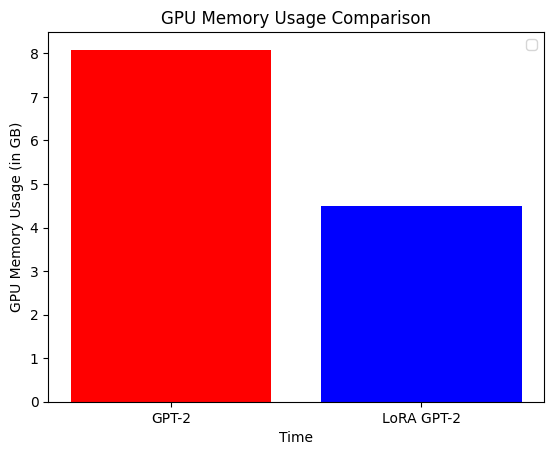

In [66]:
plt.bar(
    ["GPT-2", "LoRA GPT-2"],
    [max(gpt2_lm_memory_usage), max(lora_model_memory_usage)],
    color=["red", "blue"],
)

plt.xlabel("Time")
plt.ylabel("GPU Memory Usage (in GB)")

plt.title("GPU Memory Usage Comparison")
plt.legend()
plt.show()

In [68]:
generate_text(lora_model, "I like cricket", max_length=MAX_GENERATION_LENGTH)
generate_text(
    lora_model, "That indian hotel", max_length=MAX_GENERATION_LENGTH
)

output : I like cricket. It's not like cricket.

I like cricket because it's not like cricket.

The cricket thing is, if you want to get your cricket fix, you have to have the right equipment.

I'm a big believer in that.

The cricket thing is not like cricket, because the players are the same age.

So you need the right equipment.

But I'm not going to get into the technicalities of it, because I don't know enough about the game to do so.

So, I'm going to go through the basics.
Time take to generate : 0.55s
output : That indian hotel, which was in a good spot for the night, had been booked on a Thursday night so the hotel staff could get ready for work.

So the next morning, my boss came to pick me up and take a picture with me.

I had no idea that this was going to happen.

"What's wrong?" I ask my boss.

"I've been in the hotel for the last three days, and I can't get a good night's sleep. I'm not sure what I'm gonna do. So I go to my hotel and check it out."

So I check out the ba

In [69]:
for layer_idx in range(lora_model.backbone.num_layers):
  self_attention_layer = lora_model.backbone.get_layer(f"transformer_layer_{layer_idx}")._self_attention_layer

  query_layer = self_attention_layer._query_dense

  weight_A = query_layer.A.kernel
  weight_B = query_layer.B.kernel

  incremental_weight = tf.einsum("ab,bcd->acd",weight_A,weight_B) * (ALPHA/RANK)
  query_layer.original_layers.kernel.assign_add(incremental_weight)

  value_layer = self_attention_layer._value_dense

  weight_A = value_layer.A.kernel
  weight_B = value_layer.B.kernel

  incremental_weight = tf.einsum("ab,bcd->acd",weight_A,weight_B) * (ALPHA/RANK)
  value_layer.original_layers.kernel.assign_add(incremental_weight)

In [70]:
generate_text(lora_model, "I like cricket", max_length=MAX_GENERATION_LENGTH)
generate_text(
    lora_model, "That indian hotel", max_length=MAX_GENERATION_LENGTH
)

output : I like cricket. 
i've been watching cricket for the last few hours and i'm not really sure why.   i've been on my way to the gym, so i'm not really sure why the fuck i'm doing this.  i've been playing with my friends for a while, so i don't really know why they're here, or what the hell they're doing here.     i'm just a little kid who loves cricket
Time take to generate : 0.56s
output : That indian hotel room. i have a lot of friends there and i have a good friend who lives in the same hotel room as us.

       i was on my way to the hotel when the doors open
Time take to generate : 0.33s
